# **Salari e posizioni lavorative nella cybersecurity**
L'analisi riguarda gli stipendi percepiti da professionisti nel settore della sicurezza informatica. 


## **Struttura del Dataset `salaries`**
Il dataset contiene informazioni sulle retribuzioni annuali per varie posizioni lavorative nel campo della tecnologia, con metadati aggiuntivi come:

- **work_year**: l’anno in cui è stato registrato lo stipendio
- **experience_level**: livello di esperienza (EN = Entry, MI = Mid, SE = Senior, EX = Executive)
- **employment_type**: tipo di contratto (FT = Full-Time, PT = Part-Time, ecc.)
- **job_title**: titolo della posizione lavorativa (es. Data Scientist, Security Consultant)
- **salary**: retribuzione annuale nella valuta locale.
- **salary_in_usd**: retribuzione annuale convertita in dollari statunitensi.
- **employee_residence**: paese di residenza del dipendentew
- **remote_ratio**: percentuale di lavoro da remoto (0 = in sede, 100 = completamente remoto)
- **company_location**: paese della sede aziendale 
- **company_size**: dimensione dell’azienda (S = Small, M = Medium, L = Large)

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc
from wordcloud import WordCloud
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")
df = pd.read_csv("salaries.csv")
# ordine logico per esperienza
exp_order = ["EN", "MI", "SE", "EX"]
df["experience_level"] = pd.Categorical(df["experience_level"], categories=exp_order, ordered=True)
# Mappa codice paese -> nome completo
country_names = {
    "US": "United States", "GB": "United Kingdom", "DE": "Germany", "CA": "Canada", "IN": "India",
    "FR": "France", "ES": "Spain", "CH": "Switzerland", "IT": "Italy", "NL": "Netherlands",
    "IE": "Ireland", "AU": "Australia", "BR": "Brazil", "JP": "Japan", "AE": "United Arab Emirates",
    "BG": "Bulgaria", "BE": "Belgium", "LU": "Luxembourg", "TW": "Taiwan", "MX": "Mexico",
    "NO": "Norway", "PT": "Portugal", "SE": "Sweden", "PL": "Poland", "GR": "Greece",
    "AT": "Austria", "HU": "Hungary", "LV": "Latvia", "EG": "Egypt", "GH": "Ghana",
    "NZ": "New Zealand", "MT": "Malta", "RO": "Romania", "HR": "Croatia", "NG": "Nigeria"
}
import plotly.io as pio
pio.renderers.default = "notebook_connected"




###  **Venti lavori maggiormente retribuiti per paese**
Questo grafico mostra i 20 "job title" con lo stipendio medio più alto, uno per ciascun paese, convertito in euro. Ogni barra rappresenta un'accoppiata *paese - job title*, ordinata per stipendio. Il colore indica la posizione relativa nello spettro salariale (verde = basso, rosso = alto).
Questa visualizzazione è utile per capire **quali ruoli IT/Data sono più valorizzati a livello internazionale** e in quali paesi gli stipendi sono più competitivi per le posizioni di vertice.


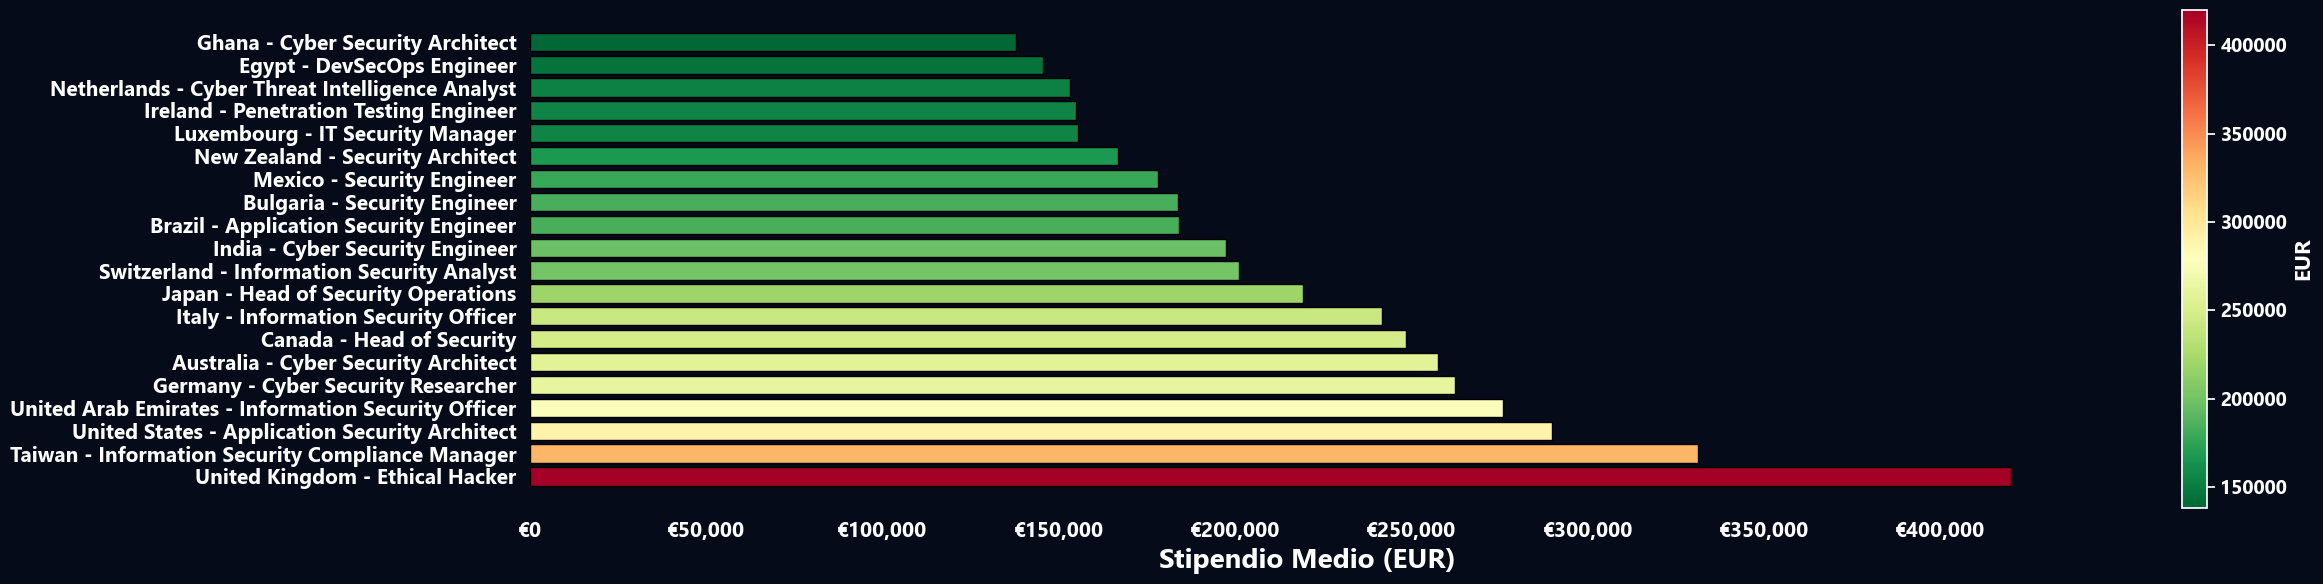

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  #
plt.rcParams["font.family"] = "Segoe UI"
plt.rcParams["font.weight"] = "bold"
# stipendio medio per ruolo 
top_paid_jobs = (
    df.groupby(["employee_residence", "job_title"])["salary_in_usd"]
      .mean()
      .reset_index()
)
# job con salario piu alto per paese
idx = top_paid_jobs.groupby("employee_residence")["salary_in_usd"].idxmax()
top_jobs_per_country = top_paid_jobs.loc[idx].sort_values(
    by="salary_in_usd", ascending=False
)
# convers USD → EUR
usd_to_eur = 0.92
top20 = top_jobs_per_country.head(20).copy()
top20["salary_eur"] = top20["salary_in_usd"] * usd_to_eur
# maappatura dei codici paese in nome esteso
top20["country_name"] = top20["employee_residence"].map(country_names)
top20["label"] = top20["country_name"] + " - " + top20["job_title"]
# colori graduati in base allo stipendio 
top20_sorted = top20.sort_values(by="salary_eur")
norm = plt.Normalize(top20_sorted["salary_eur"].min(), top20_sorted["salary_eur"].max())
colors = plt.cm.RdYlGn_r(norm(top20_sorted["salary_eur"]))
fig, ax = plt.subplots(figsize=(25, 6), facecolor='#050b18')
fig.patch.set_facecolor('#050b18')
ax.set_facecolor('#050b18')
# bars orizzontali 
bars = ax.barh(
    top20_sorted["label"],
    top20_sorted["salary_eur"],
    color=colors,
    edgecolor="black"
)
# asse X
ax.set_xlabel("Stipendio Medio (EUR)", fontsize=20, fontweight='bold', color='white')
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)
ax.invert_yaxis()  # Barre dalla più alta in alto
ax.grid(False)
# nascondere spine 
for spine in ax.spines.values():
    spine.set_visible(False)

# barra colori per scale dello stipendio
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=norm)
sm.set_array([])  # necessario per plt.colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('EUR', fontsize=16, fontweight='bold', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### **Stipendi Medi tra Paesi**

Questo grafico orizzontale mostra lo **stipendio medio per paese**, limitando l’analisi a Europa, USA e Italia.  L’Italia è evidenziata in **blu** per facilitare il confronto diretto con gli altri paesi. I colori delle altre barre variano dal **verde (stipendi più bassi)** al **rosso (stipendi più alti)**, in scala relativa.
Questa visualizzazione permette di capire **quanto è competitiva l’Italia rispetto agli altri paesi** in termini di stipendi medi nel settore tech/data.


In [33]:
def is_europe_us_or_italy(iso_code):
    # controllo esplicito per Stati Uniti e Italia
    if iso_code in ["US", "IT"]:
        return True
    try:
        # pycountry-convert per verificare se appartiene all'Europa
        return pc.country_alpha2_to_continent_code(iso_code) == "EU"
    except:
        return False
# filtro per includere solo USA, Italia o paesi europei
df_filtered = df[df["employee_residence"].apply(is_europe_us_or_italy)]
# calcolo dello stipendio medio USD per paese
salary_by_country = df_filtered.groupby("employee_residence")["salary_in_usd"] \
    .mean().reset_index()
salary_by_country.columns = ["employee_residence", "salary_in_usd"]
# conv in EUR
salary_by_country["salary_in_eur"] = salary_by_country["salary_in_usd"] * 0.88
# mappatura ISO2 → nome paese completo 
iso_to_name = {c.alpha_2: c.name for c in pycountry.countries}
salary_by_country["country_name"] = salary_by_country["employee_residence"] \
    .map(iso_to_name)
# rimozione righe senza nome paese o codice "JE" (Jersey)
salary_by_country = salary_by_country.dropna(subset=["country_name"])
salary_by_country = salary_by_country[salary_by_country["employee_residence"] != "JE"]
# separazione italia per focus
italy = salary_by_country[salary_by_country["country_name"] == "Italy"]
others = salary_by_country[salary_by_country["country_name"] != "Italy"] \
    .sort_values("salary_in_eur", ascending=False)
fig = go.Figure()

# barra per l'italia
fig.add_trace(go.Bar(
    x=italy["salary_in_eur"],
    y=italy["country_name"],
    orientation='h',
    marker=dict(color='blue')
))

# 2. Barre per gli altri paesi con sfumatura in base allo stipendio
fig.add_trace(go.Bar(
    x=others["salary_in_eur"],
    y=others["country_name"],
    orientation='h',
    marker=dict(
        color=others["salary_in_eur"],
        colorscale='RdYlGn_r',  # scala inversa rosso → verde
        colorbar=dict(
            title=dict(text="EUR", font=dict(color='white', size=16, family="Bahnschrift")),
            tickfont=dict(color='white', size=14, family="Bahnschrift")
        )
    )
))
fig.update_layout(
    title=dict(text="Media Stipendi per Paese",
               font=dict(family="Bahnschrift", size=22, color="white")),
    font=dict(family="Bahnschrift", size=16, color="white"),
    plot_bgcolor='#050b18',
    paper_bgcolor='#050b18',
    barmode='stack',
    showlegend=False,
    height=504,
    width=1631
)
# asse X (valori EUR)
fig.update_xaxes(
    tickformat=".0f",
    dtick=10000,
    title_text="Stipendio Medio (EUR)",
    title_font=dict(family="Bahnschrift", size=18, color="white"),
    tickfont=dict(family="Bahnschrift", size=16, color="white"),
    showgrid=False
)
# asse Y (nomi paesi)
fig.update_yaxes(
    tickfont=dict(family="Bahnschrift", size=16, color="white")
)
fig.show()


###  **Dieci paesi migliori per stipendio medio di un Security Consultant** 

Questo grafico mostra i **10 paesi con lo stipendio medio più alto** per il ruolo di **Security Consultant** con livello di esperienza **MI (Mid-level)**. Ogni fetta rappresenta un paese, colorato in modo distintivo, con etichetta che unisce il nome e il valore medio (in euro).  
Il formato aiuta a evidenziare le differenze **relative tra i paesi** e a mettere in risalto i migliori stipendi nel settore cybersecurity a livello internazionale.


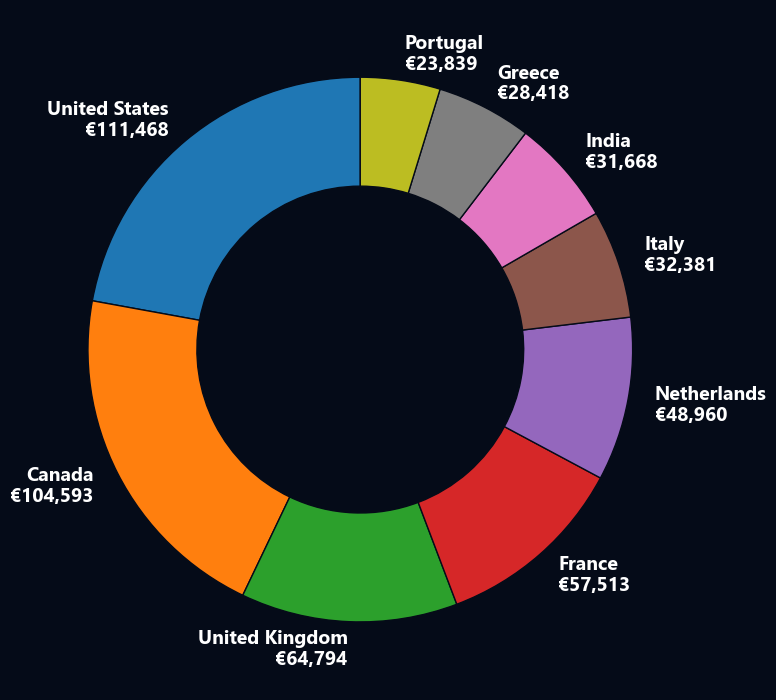

In [34]:
 # filtro su mansione "Security Consultant" o "Cyber Security Consultant" esperienza “MI” (mid‑level)
filtered_df = df[
    (df["job_title"].isin(["Security Consultant", "Cyber Security Consultant"])) &
    (df["experience_level"] == "MI")
].copy()
# convers da USD a EUR 
filtered_df["salary_eur"] = filtered_df["salary_in_usd"] * 0.92
# map del codice paese ISO 
filtered_df["country_name"] = filtered_df["employee_residence"].map(country_names)
# stipendio medio
avg_salary = (
    filtered_df.groupby("country_name")["salary_eur"]
    .mean()
    .reset_index()
    .sort_values(by="salary_eur", ascending=True)
)
#  10 paesi con stipendio medio più alto
top10 = avg_salary.sort_values(by="salary_eur", ascending=False).head(10)
labels = [
    f"{country}\n€{salary:,.0f}"
    for country, salary in zip(top10["country_name"], top10["salary_eur"])
]
color = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]
fig, ax = plt.subplots(figsize=(8, 8), facecolor="#050b18")
ax.set_facecolor("#050b18")
wedges, texts = ax.pie(
    top10["salary_eur"],
    labels=labels,
    colors=color,
    startangle=90,  
    wedgeprops=dict(width=0.4, edgecolor='#050b18'),
    textprops=dict(
        color='white',
        fontsize=14,
        fontweight='bold',
        family='Segoe UI'
    )
)
ax.set_title("", color='white')
plt.tight_layout()
plt.show()


### **Word Cloud dei ruoli lavorativi più pagati**


La word cloud mostra i **titoli di lavoro presenti nel dataset**, dimensionati in base allo **stipendio medio in USD** per ciascun ruolo. Le parole più grandi corrispondono ai ruoli più remunerativi, mentre quelle più piccole rappresentano ruoli con salari medi inferiori.
Questa visualizzazione è utile per **identificare rapidamente quali professioni dominano il mercato in termini di monetari**.


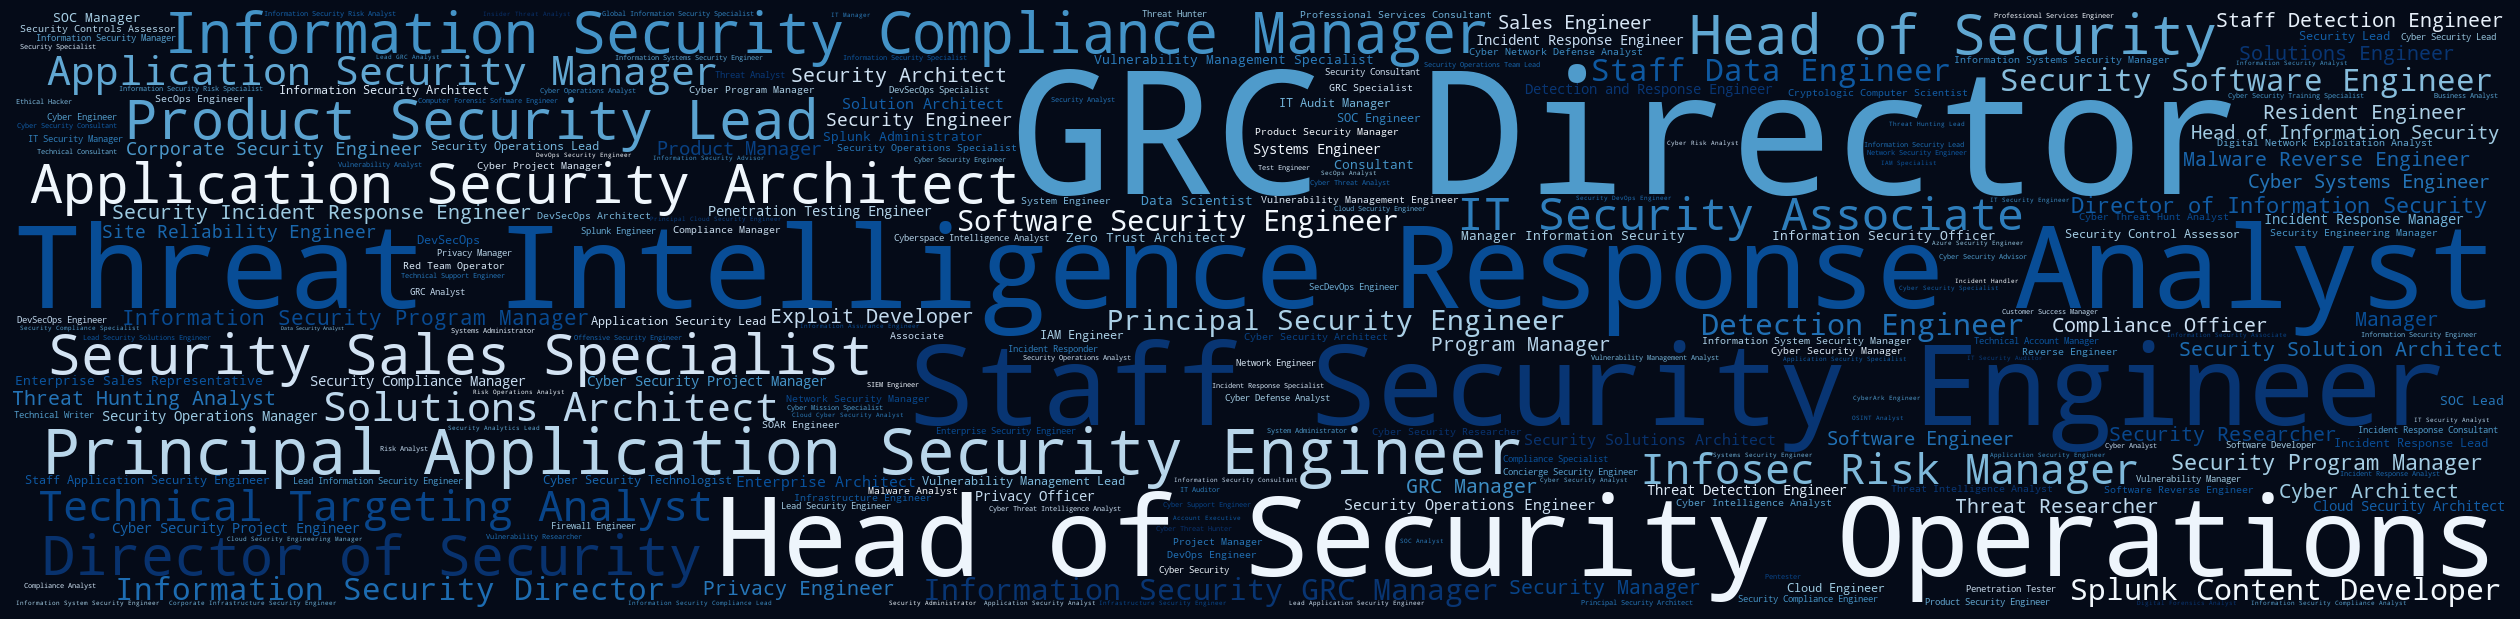

In [35]:
# raggruppamento per job_title calcolo stipendio medio 
title_weights = df.groupby("job_title")["salary_in_usd"].mean()

# wordcloud
wordcloud = WordCloud(
    width=2500,               
    height=600,               
    background_color="#050b18",  
    colormap="Blues", # scala di color toni di blu
    prefer_horizontal=1,# orientamentoorizzontale
    max_words=250, # massimo di 250 parole visualizzate
    font_path=None           
).generate_from_frequencies(title_weights)  
fig, ax = plt.subplots(figsize=(25, 6), facecolor="#050b18")
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_facecolor("#050b18")
ax.axis("off")  
plt.tight_layout(pad=0)
plt.show()